In [ ]:
from huggingface_hub import notebook_login

In [ ]:
notebook_login()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import kagglehub
import os
import random
import urllib
import shutil
import numpy as np
import google.colab.files as files
from keras.preprocessing import image
from tqdm import tqdm
%matplotlib inline

In [ ]:
print(tf.__version__)

2.18.0


In [ ]:
path = kagglehub.dataset_download("karakaggle/kaggle-cat-vs-dog-dataset")

print("Path to dataset files:", path)

100%|██████████| 787M/787M [00:07<00:00, 106MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1


In [ ]:
os.listdir(path)

['kagglecatsanddogs_3367a']

In [ ]:
dataset_path = os.path.join(path, "kagglecatsanddogs_3367a", "PetImages")

print(os.listdir(dataset_path))

['Dog', 'Cat']


In [ ]:
print("Jumlah gambar kucing:", len(os.listdir(os.path.join(dataset_path, "Cat"))))
print("Jumlah gambar anjing:", len(os.listdir(os.path.join(dataset_path, "Dog"))))

Jumlah gambar kucing: 12491
Jumlah gambar anjing: 12470


In [ ]:
try:
  os.mkdir(os.path.join(dataset_path, "train"))
  os.mkdir(os.path.join(dataset_path, "train", "dog"))
  os.mkdir(os.path.join(dataset_path, "train", "cat"))
  os.mkdir(os.path.join(dataset_path, "test"))
  os.mkdir(os.path.join(dataset_path, "test", "dog"))
  os.mkdir(os.path.join(dataset_path, "test", "cat"))
except:
  pass

In [ ]:
os.listdir(os.path.join(dataset_path, "test"))

['dog', 'cat']

In [ ]:
def data_split(source, train, test, split_size):
  files = []
  for filename in tqdm(os.listdir(source)):
    file = os.path.join(source, filename)

    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(filename + " is zero length, so ignoring.")

  training_length = int(len(files) * split_size)
  testing_length = int(len(files) - training_length)

  shuffled_set = random.sample(files, len(files))
  training_set = shuffled_set[0:training_length]
  testing_set = shuffled_set[-testing_length:]

  for filename in tqdm(training_set):
    this_file = os.path.join(source, filename)
    destination = os.path.join(train, filename)
    if os.path.exists(destination):
        pass
    else:
        shutil.copyfile(this_file, destination)

  for filename in tqdm(testing_set):
    this_file = os.path.join(source, filename)
    destination = os.path.join(test, filename)
    shutil.copyfile(this_file, destination)

In [ ]:
SPLIT_SIZE = 0.9
SOURCE_DIR_DOG = os.path.join(dataset_path, "Dog")
SOURCE_DIR_CAT = os.path.join(dataset_path, "Cat")
TRAINING_DIR_DOG = os.path.join(dataset_path, "train", "dog")
TRAINING_DIR_CAT = os.path.join(dataset_path, "train", "cat")
TEST_DIR_CAT = os.path.join(dataset_path, "test", "cat")
TEST_DIR_DOG = os.path.join(dataset_path, "test", "dog")

In [ ]:
def truncate_folder(folder):
    try:
        shutil.rmtree(folder)
    except Exception as e:
        print(f"Gagal menghapus {folder}: {e}")

In [ ]:
data_split(SOURCE_DIR_DOG, TRAINING_DIR_DOG, TEST_DIR_DOG, SPLIT_SIZE)
data_split(SOURCE_DIR_CAT, TRAINING_DIR_CAT, TEST_DIR_CAT, SPLIT_SIZE)

100%|██████████| 1250/1250 [00:00<00:00, 2311.66it/s]


In [ ]:
print('Jumlah data latih kucing', len(os.listdir(TRAINING_DIR_CAT)))
print('Jumlah data latih anjing', len(os.listdir(TRAINING_DIR_DOG)))
print('Jumlah data uji kucing', len(os.listdir(TEST_DIR_CAT)))
print('Jumlah data uji anjing', len(os.listdir(TEST_DIR_DOG)))

Jumlah data latih kucing 11241
Jumlah data latih anjing 11223
Jumlah data uji kucing 1250
Jumlah data uji anjing 1247


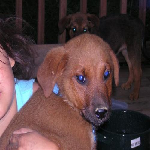

In [ ]:
image.load_img(os.path.join(TEST_DIR_DOG, os.listdir(TEST_DIR_DOG)[8]), target_size=(150,150))

## Inception-V3

In [ ]:
training_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = training_datagen.flow_from_directory(
    os.path.join(dataset_path, "train"),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)


Found 22462 images belonging to 2 classes.


In [ ]:
validation_datagen = ImageDataGenerator(
    rescale=1./25
)

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(dataset_path, "test"),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 2497 images belonging to 2 classes.


In [ ]:
weight_url = "https://drive.google.com/uc?export=download&id=11U_CKHOIrMJNaQeQxMowHwfq7gDubyBz"
weight_filename = "inceptionv3.h5"
urllib.request.urlretrieve(weight_url, weight_filename)

('inceptionv3.h5', <http.client.HTTPMessage at 0x79d5880a0b50>)

In [ ]:
pretrained = InceptionV3(input_shape=(150, 150, 3), include_top=False, weights=None)
pretrained.load_weights(weight_filename)

In [ ]:
for layer in pretrained.layers:
    layer.trainable = False

used_layer = pretrained.get_layer('mixed7')
output_layer = used_layer.output

In [ ]:
x = tf.keras.layers.Flatten()(output_layer)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = Model(pretrained.input, x)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 74, 74, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 74, 74, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 72, 72, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 72, 72, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 72, 72, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 72, 72, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 72, 72, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 72, 72, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 35, 35, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 35, 35, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 35, 35, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 33, 33, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 33, 33, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 48,036,769 (183.25 MB)

 Trainable params: 39,061,505 (149.01 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
class StopAtAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target_acc=0.90):
        super(StopAtAccuracy, self).__init__()
        self.target_acc = target_acc

    def on_epoch_end(self, epoch, logs=None):
        if logs.get("accuracy") >= self.target_acc:
            print(f"\nAkurasi mencapai {logs.get('accuracy'):.2%}, menghentikan training...")
            self.model.stop_training = True

In [ ]:
stop_callback = StopAtAccuracy(target_acc=0.95)

In [ ]:
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator,
                    callbacks=[stop_callback])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.8858 - loss: 0.3506

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


702/702 ━━━━━━━━━━━━━━━━━━━━ 179s 236ms/step - accuracy: 0.8858 - loss: 0.3505 - val_accuracy: 0.4782 - val_loss: 1.1389
Epoch 2/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 150s 214ms/step - accuracy: 0.9339 - loss: 0.1582 - val_accuracy: 0.4950 - val_loss: 0.9866
Epoch 3/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 158s 225ms/step - accuracy: 0.9446 - loss: 0.1349 - val_accuracy: 0.5134 - val_loss: 0.8100
Epoch 4/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 199s 221ms/step - accuracy: 0.9438 - loss: 0.1376 - val_accuracy: 0.4794 - val_loss: 1.0730
Epoch 5/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 151s 215ms/step - accuracy: 0.9461 - loss: 0.1392 - val_accuracy: 0.4918 - val_loss: 0.8552
Epoch 6/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 158s 225ms/step - accuracy: 0.9471 - loss: 0.1292 - val_accuracy: 0.4954 - val_loss: 1.2483
Epoch 7/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 161s 229ms/step - accuracy: 0.9505 - loss: 0.1231 - val_accuracy: 0.4910 - val_loss: 1.0564
Epoch 8/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 201s 286ms/step - accuracy: 0.9488 - loss: 0.12

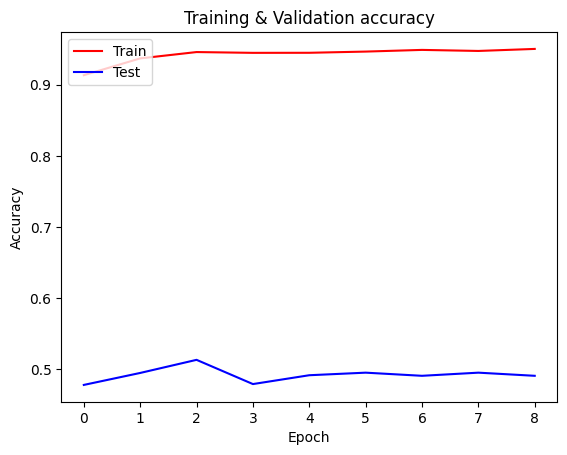

In [ ]:
epochs=range(len(history.history['accuracy']))

plt.plot(epochs, history.history['accuracy'], 'r')
plt.plot(epochs, history.history['val_accuracy'], 'b')
plt.title('Training & Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

Saving y.jpeg to y.jpeg


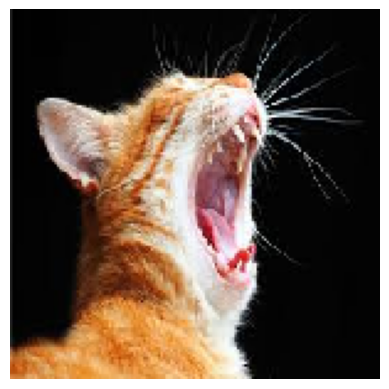

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
y.jpeg itu gambar kucing


In [ ]:
from PIL import Image

uploaded = files.upload()

for fn in uploaded.keys():
    path = '/content/' + fn

    img = image.load_img(path, target_size=(150,150))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    image_tensor = np.vstack([x])
    classes = model.predict(image_tensor)

    if classes[0] > 0.5:
        print(fn + " itu gambar anjing")
    else:
        print(fn + " itu gambar kucing")


In [ ]:
model.save("cat_dog_inception_v3.h5")

## Upload To Hugging Face

In [ ]:
from huggingface_hub import ModelCard, ModelCardData, create_repo, upload_file
import json

In [ ]:
repo_name = "inception-v3-transfer-learning"
create_repo(repo_name, private=False)

RepoUrl('https://huggingface.co/blaxx14/inception-v3-transfer-learning', endpoint='https://huggingface.co', repo_type='model', repo_id='blaxx14/inception-v3-transfer-learning')

In [ ]:
upload_file(
    path_or_fileobj="/content/cat_dog_inception_v3.h5",
    path_in_repo="cat_dog_inception_v3.h5",
    repo_id="blaxx14/inception-v3-transfer-learning"
)

cat_dog_inception_v3.h5:   0%|          | 0.00/505M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/blaxx14/inception-v3-transfer-learning/commit/a33f4ecabf141936adc6c42f423f9b53956cfef7', commit_message='Upload cat_dog_inception_v3.h5 with huggingface_hub', commit_description='', oid='a33f4ecabf141936adc6c42f423f9b53956cfef7', pr_url=None, repo_url=RepoUrl('https://huggingface.co/blaxx14/inception-v3-transfer-learning', endpoint='https://huggingface.co', repo_type='model', repo_id='blaxx14/inception-v3-transfer-learning'), pr_revision=None, pr_num=None)

In [ ]:
data = ModelCardData(
    language="en",
    library_name="tensorflow",
    license="apache-2.0",
    tags=["image-classification", "transfer-learning", "tensorflow"],
)

card = ModelCard.from_template(
    card_data=data,
    model_name="Cat vs Dog Classification",
    description="This is a fine-tuned InceptionV3 model for image classification tasks.",
)

with open("README.md", "w") as f:
    f.write(card.content)

In [ ]:
upload_file(
    path_or_fileobj="README.md",
    path_in_repo="README.md",
    repo_id="blaxx14/inception-v3-transfer-learning"
)

CommitInfo(commit_url='https://huggingface.co/blaxx14/inception-v3-transfer-learning/commit/dfbf09bf645c2a8c7086855c04b4f6aac8b7de6c', commit_message='Upload README.md with huggingface_hub', commit_description='', oid='dfbf09bf645c2a8c7086855c04b4f6aac8b7de6c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/blaxx14/inception-v3-transfer-learning', endpoint='https://huggingface.co', repo_type='model', repo_id='blaxx14/inception-v3-transfer-learning'), pr_revision=None, pr_num=None)

In [ ]:
with open("training_history.json", "w") as f:
    json.dump(history.history, f)

In [ ]:
repo_id = "blaxx14/cat-vs-dog-inceptionv3"

upload_file(
    path_or_fileobj="training_history.json",
    path_in_repo="training_history.json",
    repo_id=repo_id
)

CommitInfo(commit_url='https://huggingface.co/blaxx14/cat-vs-dog-inceptionv3/commit/bc0e3423a1f0d5d4d9adb608fb32763e42f19a04', commit_message='Upload training_history.json with huggingface_hub', commit_description='', oid='bc0e3423a1f0d5d4d9adb608fb32763e42f19a04', pr_url=None, repo_url=RepoUrl('https://huggingface.co/blaxx14/cat-vs-dog-inceptionv3', endpoint='https://huggingface.co', repo_type='model', repo_id='blaxx14/cat-vs-dog-inceptionv3'), pr_revision=None, pr_num=None)

In [ ]:
with open("README.md", "a") as f:
    f.write("\n## Training History\n")
    f.write("Training history is available in the repository:\n")
    f.write("- [training_history.json](./training_history.json)\n")
    f.write("- [training_history.csv](./training_history.csv)\n")

upload_file(
    path_or_fileobj="README.md",
    path_in_repo="README.md",
    repo_id=repo_id
)

CommitInfo(commit_url='https://huggingface.co/blaxx14/cat-vs-dog-inceptionv3/commit/ee92c1d24184543666c66514e88d67252c39028f', commit_message='Upload README.md with huggingface_hub', commit_description='', oid='ee92c1d24184543666c66514e88d67252c39028f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/blaxx14/cat-vs-dog-inceptionv3', endpoint='https://huggingface.co', repo_type='model', repo_id='blaxx14/cat-vs-dog-inceptionv3'), pr_revision=None, pr_num=None)

## ResNet50

In [ ]:
train_datagen_resnet = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

training_generator_resnet = train_datagen_resnet.flow_from_directory(
    os.path.join(dataset_path, "train"),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 22463 images belonging to 2 classes.


In [ ]:
validation_datagen_resnet = ImageDataGenerator(
    rescale=1./255
)

validation_generator_resnet = validation_datagen_resnet.flow_from_directory(
    os.path.join(dataset_path, "test"),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 2496 images belonging to 2 classes.


In [ ]:
def feature_extraction(inputs):
  resnet_model = ResNet50(
      include_top=False,
      weights='imagenet',
      input_shape=(224,224,3),
      pooling='max'
  )

  return resnet_model(inputs)

In [ ]:
def fully_connected_layers(inputs):
  y = tf.keras.layers.Flatten()(inputs)
  y = tf.keras.layers.Dense(1024, activation='relu')(y)
  y = tf.keras.layers.Dropout(0.2)(y)
  y = tf.keras.layers.Dense(512, activation='relu')(y)
  y = tf.keras.layers.Dense(1, activation='sigmoid')(y)

  return y

In [ ]:
def full_model(inputs):
  resnet_model = feature_extraction(inputs)
  output = fully_connected_layers(resnet_model)

  return output

In [ ]:
input = tf.keras.Input(shape=(224, 224, 3))
model_resnet = Model(inputs=input, outputs=full_model(input))
model_resnet.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,211,201 (99.99 MB)

 Trainable params: 26,158,081 (99.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
model_resnet.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_resnet = model_resnet.fit(training_generator_resnet,
                    epochs=20,
                    validation_data=validation_generator_resnet,
                    callbacks=[stop_callback])

Epoch 1/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 335s 477ms/step - accuracy: 0.9395 - loss: 0.1503 - val_accuracy: 0.6510 - val_loss: 0.5262
Epoch 2/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 334s 476ms/step - accuracy: 0.9318 - loss: 0.1661 - val_accuracy: 0.9415 - val_loss: 0.1360
Epoch 3/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 337s 479ms/step - accuracy: 0.9389 - loss: 0.1494 - val_accuracy: 0.9347 - val_loss: 0.1667
Epoch 4/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 332s 472ms/step - accuracy: 0.9444 - loss: 0.1426 - val_accuracy: 0.9447 - val_loss: 0.1411
Epoch 5/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 334s 476ms/step - accuracy: 0.9455 - loss: 0.1340 - val_accuracy: 0.7913 - val_loss: 0.5269
Epoch 6/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 334s 476ms/step - accuracy: 0.9468 - loss: 0.1319 - val_accuracy: 0.9151 - val_loss: 0.2177
Epoch 7/20
613/702 ━━━━━━━━━━━━━━━━━━━━ 41s 465ms/step - accuracy: 0.9490 - loss: 0.1300

In [ ]:
epochs=range(len(history_resnet.history['accuracy']))

plt.plot(epochs, history_resnet.history['accuracy'], 'r')
plt.plot(epochs, history_resnet.history['val_accuracy'], 'b')
plt.title('Training & Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  image_tensor = np.vstack([x])
  classes = model_resnet.predict(image_tensor)
  # print(classes)
  # print(classes[0])
  if classes[0]>0.5:
    print(fn + " itu gambar anjing")
  else:
    print(fn + " itu gambar kucing")